# ML Pipeline Index:Cat vs. Dog Classifier
0. [Import Needed Python Libraries](#import-need-python-libs)
1. [Data Collection](#data-collection)
2. [Data Preprocessing](#data-preprocessing)
3. [Data Splitting](#data-splitting)
4. [Model Definition](#model-definition)
5. [Model Training](#model-training)
6. [Model Evaluation](#model-evaluation)
7. [Hyperparameter Tuning (Optional)](#hyperparameter-tuning-optional)
8. [Model Saving](#model-saving)
9. [Inference/Deployment](#inference-deployment)

<a id="import-need-python-libs"></a>
# 0. Import Needed Python Libraries
Import all necessary Python libraries for the Cat vs. Dog classification pipeline.

In [ ]:
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
from torch import nn,optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.models.densenet import _DenseBlock, _Transition, _DenseLayer
import shutil
import zipfile
import os
import random
from PIL import Image
import numpy as np

<a id="data-collection"></a>
# 1. Data Collection
Gather and load the dataset for the Cat vs. Dog classification task.

In [54]:
!kaggle competitions download -c dogs-vs-cats

 92%|████████████████████████████████████▉   | 751M/812M [00:00<00:00, 1.25GB/s]
100%|████████████████████████████████████████| 812M/812M [00:00<00:00, 1.27GB/s]


In [55]:
with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('Cat_Dog_data')

with zipfile.ZipFile('Cat_Dog_data/train.zip', 'r') as zip_ref:
    zip_ref.extractall('Cat_Dog_data/rawtrain')

with zipfile.ZipFile('Cat_Dog_data/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('Cat_Dog_data/rawtest')

In [ ]:
original_train_dir ='Cat_Dog_data/rawtrain/train'
original_test_dir = 'Cat_Dog_data/rawtest/test1'
train_dir='Cat_Dog_data/train'
val_dir=  'Cat_Dog_data/valid'
test_dir= 'Cat_Dog_data/test'

os.makedirs('../Datasets', exist_ok=True)
for category in ['dog', 'cat']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

os.makedirs(test_dir, exist_ok=True)

alltrain_filenames = os.listdir(original_train_dir)
alltest_filenames = os.listdir(original_test_dir)

cat_files = [name for name in alltrain_filenames if name.startswith("cat")]
dog_files = [name for name in alltrain_filenames if name.startswith("dog")]

random.seed(42)
random.shuffle(cat_files)
random.shuffle(dog_files)

split_cat = int(0.8 * len(cat_files))
split_dog = int(0.8 * len(dog_files))

train_cats, val_cats = cat_files[:split_cat], cat_files[split_cat:]
train_dogs, val_dogs = dog_files[:split_dog], dog_files[split_dog:]

def copy_files(files, src, dst):
    for f in files:
        shutil.move(os.path.join(src, f), os.path.join(dst, f))

copy_files(train_cats, original_train_dir, os.path.join(train_dir, 'cat'))
copy_files(val_cats, original_train_dir, os.path.join(val_dir, 'cat'))
copy_files(train_dogs, original_train_dir, os.path.join(train_dir, 'dog'))
copy_files(val_dogs, original_train_dir, os.path.join(val_dir, 'dog'))
copy_files(alltest_filenames, original_test_dir, test_dir)

# Move the entire Cat_Dog_data folder to Datasets/Cat_Dog_data
shutil.move('Cat_Dog_data', '../Datasets/Cat_Dog_data')
# Clean up the original directories
!rm -rf '../Datasets/Cat_Dog_data/rawtrain'
!rm -rf '../Datasets/Cat_Dog_data/rawtest'
!rm -rf '../Datasets/Cat_Dog_data/train.zip'
!rm -rf '../Datasets/Cat_Dog_data/test1.zip'
!rm -rf '../Datasets/dogs-vs-cats.zip'

<a id="data-preprocessing"></a>
# 2. Data Preprocessing
Clean, normalize, and transform the images and labels as needed.

In [57]:
data_dir = '../Datasets/Cat_Dog_data'
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/valid', transform=val_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=128)

<a id="data-splitting"></a>
# 3. Data Splitting
Divide the dataset into training, validation, and test sets.

In [58]:
# Data splitting already made in the data collection step

<a id="model-definition"></a>
# 4. Model Definition
Choose and define the machine learning model architecture.

#### Create Simple CNN Model
this is a demo , model may not working in training due to matrix sizes not matching

In [59]:
class model_SimpleCNN(nn.Module):
    def __init__(self):
        super(model_SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x



#### Create a model using Sequential and inculde the Simple model class as a layer

In [60]:
model_simple_seq = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    model_SimpleCNN(),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    model_SimpleCNN(),
    nn.Flatten(),
    nn.Linear(32 * 56 * 56, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 2)
)
model_simple_seq 

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): model_SimpleCNN(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=100352, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=2, bias=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): model_SimpleCNN(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_fea

### Create a model with Sequential and OrderedDict

In [ ]:


model_simple_seq = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)),
    ('relu1', nn.ReLU()),
    ('pool1', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
    ('conv2', nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)),
    ('relu2', nn.ReLU()),
    ('pool2', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
    ('flatten', nn.Flatten()),
    ('fc1', nn.Linear(32 * 56 * 56, 256)),
    ('relu3', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(256, 2))
]))

### create the Densenet121 as a layered 

In [ ]:


class CatDogDensenet121(nn.Module):
    def __init__(self):
        super(CatDogDensenet121, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
            _DenseBlock(
                num_layers=6,
                num_input_features=64,
                bn_size=2,
                growth_rate=32,
                drop_rate=0
            ),
            _Transition(
                num_input_features=256,
                num_output_features=128
            ),
            _DenseBlock(
                num_layers=12,
                num_input_features=128,
                bn_size=2,
                growth_rate=32,
                drop_rate=0
            ),
            _Transition(
                num_input_features=512,
                num_output_features=256
            ),
            _DenseBlock(
                num_layers=24,
                num_input_features=256,
                bn_size=2,
                growth_rate=32,
                drop_rate=0
            ),
            _Transition(
                num_input_features=1024,
                num_output_features=512
            ),
            _DenseBlock(
                num_layers=16,
                num_input_features=512,
                bn_size=2,
                growth_rate=32,
                drop_rate=0
            ),
            nn.BatchNorm2d(1024)
        )
        self.classifier = nn.Linear(1024, 1000)

    def forward(self, x):
        features = self.features(x)
        out = nn.functional.relu(features, inplace=True)
        out = nn.functional.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [63]:
model = CatDogDensenet121()
print(model)

CatDogDensenet121(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=Tru

### Create a model with has 3 main steps feature,transition and classifier 
the model has Sequential,OrderedDict and include model_SimpleCNN in the feature 

In [64]:
class model_2(nn.Module):
    def __init__(self):
        super(model_2, self).__init__()
        self.feature = nn.Sequential(OrderedDict([
                        ('conv1', nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)),
                        ('relu1', nn.ReLU()),
                        ('pool1', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
                        ('conv2', nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)),
                        ('relu2', nn.ReLU()),
                        ('pool2', nn.MaxPool2d(kernel_size=2, stride=2, padding=0)),
                        ('model_SimpleCNN', model_SimpleCNN()),
                        ('flatten', nn.Flatten()),
                        ('fc1', nn.Linear(32 * 56 * 56, 256)),
                        ('relu3', nn.ReLU()),
                        ('dropout', nn.Dropout(0.5)),
                        ('fc2', nn.Linear(256, 2))
                   ]))
        self.transition = nn.Sequential(
           nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
           nn.ReLU(),
           nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
       )
        self.classifier = nn.Sequential(
           nn.Flatten(),
           nn.Linear(64 * 28 * 28, 256),
           nn.ReLU(),
           nn.Dropout(0.5),
           nn.Linear(256, 2)
       )

    def forward(self, x):
        x = self.feature(x)
        x = self.transition(x)
        x = self.classifier(x)
        return x
       



In [65]:
model = model_2()
model

model_2(
  (feature): Sequential(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (model_SimpleCNN): model_SimpleCNN(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fc1): Linear(in_features=100352, out_features=256, bias=True)
      (fc2): Linear(in_features=256, out_features=2, bias=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=100352, out_features=256, bias=True)
  

### create a model with varient input size and hidden layers

In [66]:
class Classifier(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        ''' Builds a feedforward network with arbitrary hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input layer
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
        
        '''
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [67]:
model=Classifier(500,10,[255,128,64,32,16])
model

Classifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=500, out_features=255, bias=True)
    (1): Linear(in_features=255, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (output): Linear(in_features=16, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## PyTorch Loss Functions Cheat Sheet

This section provides a concise overview of commonly used loss functions in PyTorch, grouped by task:

---

### 1. Regression Losses

- **L1Loss**: Mean Absolute Error (MAE). Robust to outliers.
- **MSELoss**: Mean Squared Error (L2 loss). Standard for regression; penalizes large errors more.
- **SmoothL1Loss**: Hybrid of L1 and L2; less sensitive to outliers than MSE. Used in object detection.
- **HuberLoss**: Like SmoothL1, but with a tunable threshold for outlier sensitivity.
- **PoissonNLLLoss**: For count data with Poisson distribution.
- **GaussianNLLLoss**: For regression with predicted mean and variance (uncertainty estimation).

---

### 2. Binary Classification Losses

- **BCELoss**: Binary Cross Entropy. Use with probabilities (after sigmoid).
- **BCEWithLogitsLoss**: Combines sigmoid and BCE in one step (more stable). Preferred for binary/multi-label tasks.

---

### 3. Multi-Class Classification Losses

- **CrossEntropyLoss**: For multi-class, single-label classification. Input: logits; Target: class indices.
- **NLLLoss**: Negative Log Likelihood. Use with log-probabilities (e.g., after LogSoftmax).
- **NLLLoss2d**: Deprecated; use NLLLoss for 2D data.

---

### 4. Multi-Label Classification Losses

- **MultiLabelMarginLoss**: For multi-label tasks with integer targets (rarely used).
- **MultiLabelSoftMarginLoss**: For multi-label classification with probabilities.

---

### 5. Ranking and Embedding Losses

- **HingeEmbeddingLoss**: For learning similarity/dissimilarity (e.g., Siamese networks).
- **CosineEmbeddingLoss**: For learning similarity based on cosine distance.
- **MarginRankingLoss**: For ranking pairs (learning to rank).
- **MultiMarginLoss**: Multi-class margin-based loss (rarely used).
- **TripletMarginLoss**: For metric learning with triplets (anchor, positive, negative).
- **TripletMarginWithDistanceLoss**: Like TripletMarginLoss, but allows custom distance functions.

---

### 6. Sequence and Special Losses

- **CTCLoss**: Connectionist Temporal Classification. For unaligned sequence-to-sequence tasks (e.g., speech recognition).
- **KLDivLoss**: Kullback-Leibler Divergence. For comparing probability distributions (e.g., distillation, VAEs).

---

#### When to Use Which

- **Regression**: Use `MSELoss` or `L1Loss`.
- **Multi-class classification**: Use `CrossEntropyLoss`.
- **Binary/multi-label classification**: Use `BCEWithLogitsLoss`.
- **Unaligned sequence prediction**: Use `CTCLoss`.
- **Metric/embedding learning**: Use `TripletMarginLoss` or `CosineEmbeddingLoss`.
- **Distribution matching**: Use `KLDivLoss` (e.g., for knowledge distillation, VAEs).
---

#### Example Usage
```python
criterion = nn.CrossEntropyLoss()
```

## PyTorch Optimizers Cheat Sheet

This section provides a concise overview of commonly used optimizers in PyTorch, grouped by type:

---

### 1. Basic Gradient Descent
- **SGD**: Stochastic Gradient Descent. Use for simple tasks or when you want full control (can add momentum, nesterov, etc.).

---

### 2. Momentum-Based Optimizers
- **SGD with Momentum**: Adds momentum to SGD, helps accelerate convergence and escape local minima.
- **RMSprop**: Maintains a moving average of squared gradients. Good for recurrent neural networks and non-stationary objectives.
- **Adagrad**: Adapts learning rate for each parameter. Good for sparse data, but learning rate can become very small.
- **Adadelta**: Extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate.
- **Adam**: Adaptive Moment Estimation. Combines momentum and RMSprop. Default choice for most deep learning tasks.
- **AdamW**: Like Adam, but decouples weight decay from the gradient update. Preferred for many modern architectures.
- **Nadam**: Adam with Nesterov momentum.

---

### 3. Second-Order and Advanced Optimizers
- **LBFGS**: Limited-memory BFGS. For small datasets and full-batch optimization (not for mini-batch SGD).
- **ASGD**: Averaged SGD. Rarely used, for some specific convergence properties.
- **Rprop**: Resilient backpropagation. For shallow networks, not common in deep learning.

---

#### When to Use Which
- **Start with Adam or AdamW** for most deep learning tasks.
- **SGD with momentum** is often used for image classification and large-scale tasks (especially with learning rate schedules).
- **RMSprop** is good for RNNs and non-stationary problems.
- **Adagrad/Adadelta** for sparse data or NLP.
- **LBFGS** for small datasets and full-batch optimization.

---

#### Example Usage
```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```


# using Transfer learning 

In [68]:
densenet121CatDogModel = models.densenet121(weights='DEFAULT')

# Freeze parameters so we don't backprop through them
for param in densenet121CatDogModel.parameters():
    param.requires_grad = False

densenet121CatDogModel.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))
#Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(densenet121CatDogModel.classifier.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

In [69]:
# Load the checkpoint for densenet121CatDogModel if exists
if  os.path.exists('../checkpoints/densenet121_catdog_checkpoint.pth'):
    checkpoint = torch.load('../checkpoints/densenet121_catdog_checkpoint.pth', map_location=device)
    densenet121CatDogModel.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Checkpoint loaded for densenet121CatDogModel")


### define the validation function 

In [70]:
def validation(model, valloader, criterion, device):
    accuracy = 0
    test_loss = 0
    for images, labels in valloader:
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accuracy 
        # Model's output is log-softmax, take exponential to get the probabilities
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true label
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()

    return test_loss, accuracy

### define the training function

In [71]:
def train(model, trainloader, valloader, criterion, optimizer, epochs=5, device='cpu', print_every=40):
    model.to(device)
    steps = 0
    running_loss = 0
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            steps += 1
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    val_loss, accuracy = validation(model, valloader, criterion, device)

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(val_loss/len(valloader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(valloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

<a id="model-training"></a>
# 5. Model Training
Train the model using the training data.

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Train the densenet121CatDogModel using the existing trainloader, valloader, criterion, and optimizer
train(densenet121CatDogModel, trainloader, valloader, criterion, optimizer, epochs=1, device=device, print_every=40)

Using device: cuda
Epoch: 1/1..  Training Loss: 0.232..  Validation Loss: 0.047..  Validation Accuracy: 0.982
Epoch: 1/1..  Training Loss: 0.145..  Validation Loss: 0.055..  Validation Accuracy: 0.981
Epoch: 1/1..  Training Loss: 0.151..  Validation Loss: 0.052..  Validation Accuracy: 0.982


<a id="model-evaluation"></a>
# 6. Model Evaluation
Evaluate the model's performance on the validation and/or test data.

In [73]:
# Set the model to evaluation mode
densenet121CatDogModel.eval()
val_loss, val_accuracy = validation(densenet121CatDogModel, valloader, criterion, device=device)
print(f"Validation Loss: {val_loss / len(valloader):.3f}")
print(f"Validation Accuracy: {val_accuracy / len(valloader):.3f}")
# Save the trained model's state_dict and relevant information


Validation Loss: 0.043
Validation Accuracy: 0.986


<a id="hyperparameter-tuning-optional"></a>
# 7. Hyperparameter Tuning (Optional)
Adjust model parameters to improve performance.

<a id="model-saving"></a>
# 8. Model Saving
Save the trained model for future inference or deployment.

In [76]:
# Save the trained densenet121CatDogModel's state_dict and relevant information
os.makedirs('../checkpoints', exist_ok=True)
checkpoint = {
    'model_state_dict': densenet121CatDogModel.state_dict(),
    'classifier': densenet121CatDogModel.classifier,
    'class_to_idx': train_data.class_to_idx,
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(checkpoint, '../checkpoints/densenet121_catdog_checkpoint.pth')
print("Model saved to ../checkpoints/densenet121_catdog_checkpoint.pth")


Model saved to ../checkpoints/densenet121_catdog_checkpoint.pth


<a id="inference-deployment"></a>
# 9. Inference/Deployment
Use the trained model to make predictions on new, unseen data.

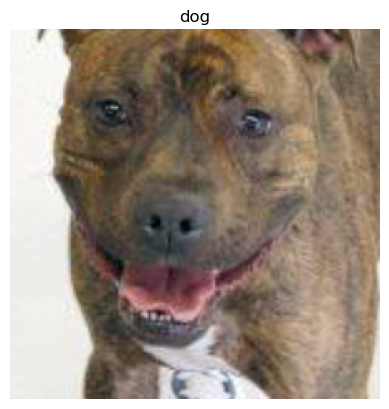

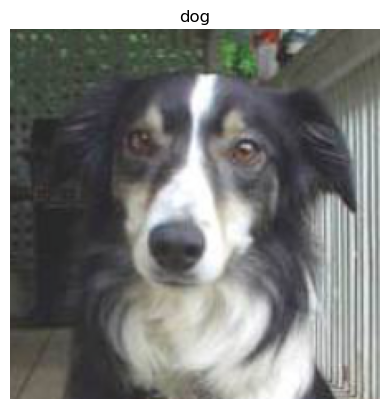

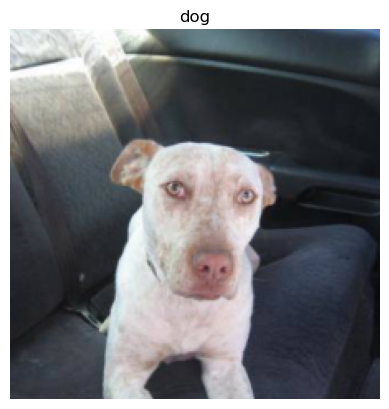

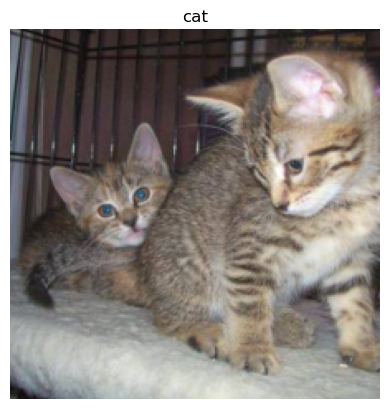

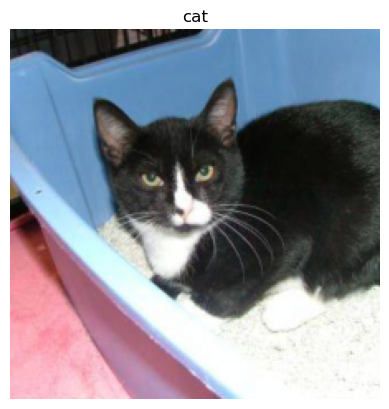

In [ ]:


test_dir=data_dir + '/test'
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a tensor
    '''
    image = Image.open(image_path).convert('RGB')
    # Apply the same transforms as validation (resize, center crop, to tensor, normalize)
    img = val_transforms(image)
    return img

def imshow(img, ax=None, title=None):
    '''Imshow for Tensor.'''
    if ax is None:
        fig, ax = plt.subplots()
    # Unnormalize
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

# Get class names from train_data
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}

# Pick a few test images to visualize
test_images = os.listdir(test_dir)
sample_images = random.sample(test_images, 5)

densenet121CatDogModel.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet121CatDogModel.to(device)

for img_name in sample_images:
    img_path = os.path.join(test_dir, img_name)
    img_tensor = process_image(img_path).unsqueeze(0).to(device)
    with torch.no_grad():
        output = densenet121CatDogModel(img_tensor)
        _, pred = torch.max(output, 1)
        pred_class = idx_to_class[pred.item()]
    imshow(process_image(img_path), title=pred_class)
    plt.show()